# Exploratory Clustering

This notebook is just meant to do some initial exploratory clustering on top of the different types of data that we have downloaded and analyze some of the results of the initial clusters formed. The analysis includes purity measure and distance between clusters

## Importing Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import os
import glob
import pickle

from utils.directory_utils import *
from utils.general_utils import *

from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import seasonal_decompose

## Data

### Loading Heart Rate Time Series Data

In [2]:
heart_rate_data_directory_path = f'../data/data_files/Saksham/heart/'
all_heart_rate_data = []
for file_path in glob.glob(heart_rate_data_directory_path + '*.pickle'):
    heart_rate_data_raw = pickle.load(open(file_path, 'rb'))
    day_heart_rate_data_array = get_attribute_val_array_by_minute(heart_rate_data_raw, 'value')
    if day_heart_rate_data_array.shape != (0,) and not np.isnan(day_heart_rate_data_array).all():
        all_heart_rate_data.append(day_heart_rate_data_array)
heart_data = np.array(all_heart_rate_data)

In [3]:
heart_data = remove_nans_from_array(heart_data)

In [4]:
heart_data

array([[ 90.,  93.,  85., ..., 101., 103., 105.],
       [ 96., 102.,  94., ...,  92.,  86.,  90.],
       [ 93.,  88.,  89., ...,  82.,  85.,  78.],
       ...,
       [ 98., 100., 100., ...,  81.,  80.,  83.],
       [ 79.,  80.,  82., ...,  83.,  90.,  90.],
       [ 86.,  87.,  91., ...,  99.,  97.,  95.]])

In [5]:
np.isnan(heart_data).any()

False

In [6]:
heart_data.shape

(69, 1440)

In [16]:
reduced_heart_data = reduce_time_series_dimension(heart_data, 15)
reduced_heart_data.shape

(69, 96)

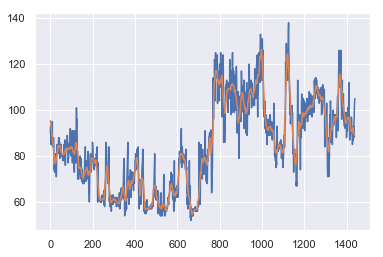

In [14]:
heart_trends = []
for day in heart_data:
    result = seasonal_decompose(day, model='additive', freq=15, extrapolate_trend='freq')
    heart_trends = heart_trends + [result.trend]
heart_trends = np.array(heart_trends)
plt.plot(heart_data[0])
plt.plot(heart_trends[0])
heart_trends = remove_nans_from_array(heart_trends)

In [17]:
reduced_heart_trends = reduce_time_series_dimension(heart_trends, 15)
reduced_heart_trends.shape

(69, 96)

#### K-Means - Euclidean

In [31]:
kmeans_mod = KMeans(n_clusters=4)
cluster_assignments = kmeans_mod.fit_predict(reduced_heart_trends)
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2, 3]), array([10, 27, 19, 13], dtype=int64))

In [32]:
np.where(cluster_assignments==0)

(array([ 4,  9, 11, 13, 16, 18, 20, 23, 32, 53], dtype=int64),)

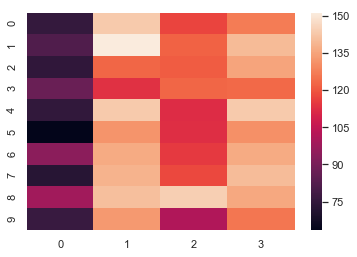

In [33]:
cluster_dist = kmeans_mod.fit_transform(reduced_heart_trends)
#cluster_dist = cluster_dist - np.mean(cluster_dist)
#cluster_dist = cluster_dist / np.std(cluster_dist)
sns.heatmap(cluster_dist[cluster_assignments==0, :])

In [34]:
np.mean(cluster_dist[cluster_assignments==3], axis=0)

array([140.54787411,  93.58344673, 117.97421466, 124.90228503])

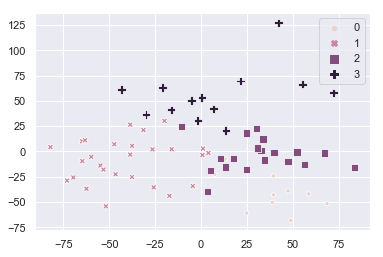

In [35]:
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments, size=cluster_assignments)

#### K-Means - DTW

In [27]:
%%time
clusterer = TimeSeriesKMeans(4, metric='dtw', max_iter=10)
cluster_assignments = clusterer.fit_predict(reduced_heart_trends[:, :])
np.unique(cluster_assignments, return_counts=True)

2784.451 --> 2015.802 --> 1938.960 --> 1934.868 --> 1934.868 --> 
Wall time: 26.9 s


In [28]:
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([ 6,  9, 37, 17], dtype=int64))

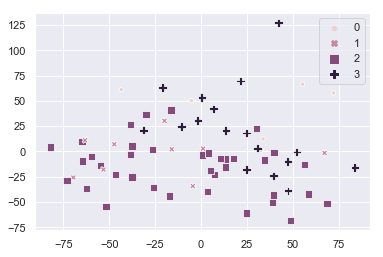

In [29]:
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments, size=cluster_assignments)